# FraudLens Model Training
This notebook loads Facebook-scraped datasets, preprocesses posts and reviews, and trains a hybrid model using TF-IDF + Isolation Forest.

In [101]:
!pip install seaborn
!pip install sentence-transformers
!pip install altair

In [102]:

import os
import json
import re
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
import joblib

# Define dataset directory
data_dir = Path("..") / "data"
combined_df = []
reviews_corpus = []
print("All JSON files in data/:", list(data_dir.glob("*.json")))
print("path is:", data_dir)

matching_files = list(data_dir.glob("final_scraped_dataset_*.json"))
print("Matching files:", matching_files)

for file in matching_files:
    try:
        with open(file, "r", encoding="utf-8") as f:
            data = json.load(f)

            # ✅ Safely load posts
            posts = data.get("Posts", [])
            if isinstance(posts, list) and all(isinstance(p, dict) for p in posts):
                posts_df = pd.DataFrame(posts)
                posts_df["About"] = [data.get("About", "")] * len(posts_df)
                posts_df["Recommendation"] = [data.get("Recommendation", "")] * len(posts_df)
                combined_df.append(posts_df)
            else:
                print(f"⚠️ Skipping file (invalid Posts list): {file.name}")

            # ✅ Collect all review strings
            for r in data.get("Reviews", []):
                if isinstance(r, dict) and r.get("Review"):
                    reviews_corpus.append(r["Review"])

    except Exception as e:
        print(f"❌ Error reading {file.name}: {e}")





df = pd.concat(combined_df, ignore_index=True) if combined_df else pd.DataFrame()
print("✅ Total posts loaded:", len(df))


All JSON files in data/: [WindowsPath('../data/final_scraped_dataset_100065151415346.json'), WindowsPath('../data/final_scraped_dataset_100075925544978.json'), WindowsPath('../data/final_scraped_dataset_100079608703063.json'), WindowsPath('../data/final_scraped_dataset_61551760628634.json'), WindowsPath('../data/final_scraped_dataset_61554401304789.json'), WindowsPath('../data/final_scraped_dataset_61554683844564.json'), WindowsPath('../data/final_scraped_dataset_61558630673177.json'), WindowsPath('../data/final_scraped_dataset_61559671449720.json'), WindowsPath('../data/final_scraped_dataset_apexlaptops.json'), WindowsPath('../data/final_scraped_dataset_cakesbynimna.json'), WindowsPath('../data/final_scraped_dataset_cartpet_republic.json'), WindowsPath('../data/final_scraped_dataset_doctormobile.json'), WindowsPath('../data/final_scraped_dataset_geniusmobile.json'), WindowsPath('../data/final_scraped_dataset_indikaconstruction.handapangoda.json'), WindowsPath('../data/final_scraped_da

In [103]:

def clean_text(text):
    text = text.lower()
    text = re.sub(r'… see more', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text.strip()

def preprocess(df):
    df['Cleaned Content'] = df['Post Content'].fillna("").apply(clean_text)
    df['Post Length'] = df['Cleaned Content'].apply(len)
    df['Num Comments'] = df['Comments'].apply(len)
    df['Total Reactions'] = df['Reactions'].apply(lambda x: sum(x.values()) if isinstance(x, dict) else 0)
    df['Angry Ratio'] = df['Reactions'].apply(lambda x: x.get('Angry', 0) / sum(x.values()) if sum(x.values()) > 0 else 0)
    df['Sad Ratio'] = df['Reactions'].apply(lambda x: x.get('Sad', 0) / sum(x.values()) if sum(x.values()) > 0 else 0)
    df['Haha Ratio'] = df['Reactions'].apply(lambda x: x.get('Haha', 0) / sum(x.values()) if sum(x.values()) > 0 else 0)
    df['Love Ratio'] = df['Reactions'].apply(lambda x: x.get('Love', 0) / sum(x.values()) if sum(x.values()) > 0 else 0)
    return df

if not df.empty:
    df = preprocess(df)
    print("✅ Preprocessing complete.")
    display(display(df))
else:
    print("⚠️ No data to preprocess.")


✅ Preprocessing complete.


,Post Content,Comments,Reactions,Timestamp,About,Recommendation,Cleaned Content,Post Length,Num Comments,Total Reactions,Angry Ratio,Sad Ratio,Haha Ratio,Love Ratio
0,https://web.facebook.com/share/18nzCqxRiR/,[],{},2025-04-21T13:41:27.492766,"{'Address': 'Colombo, Sri Lanka'}",not available,,0,0,0,0.0,0.0,0.0,0.000000
1,https://web.facebook.com/share/18nzCqxRiR/,[],{},2025-04-21T13:41:27.498857,"{'Address': 'Colombo, Sri Lanka'}",not available,,0,0,0,0.0,0.0,0.0,0.000000
2,https://web.facebook.com/share/18nzCqxRiR/,[],{},2025-04-21T13:41:27.502851,"{'Address': 'Colombo, Sri Lanka'}",not available,,0,0,0,0.0,0.0,0.0,0.000000
3,https://web.facebook.com/share/18nzCqxRiR/,[],{},2025-04-21T13:41:27.511861,"{'Address': 'Colombo, Sri Lanka'}",not available,,0,0,0,0.0,0.0,0.0,0.000000
4,No Text,[],{},2025-04-21T13:41:27.515981,"{'Address': 'Colombo, Sri Lanka'}",not available,no text,7,0,0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,වොයිලා අපේ අතින් නිමවුණු කේක් නිර්මාණ ලස්සනයි...,[සුපිරි],"{'Like': 236, 'Love': 29}",2025-04-21T15:49:55.497901,"{'Address': 'No 233/2/3,Kaduwela road,Koswatta...",98% recommend (373 reviews)﻿,0771592591 13,17,1,265,0.0,0.0,0.0,0.109434
455,වොයිලා අපේ අතින් නිමවුණු කේක් නිර්මාණ ලස්සනයි...,"[ඇත්තටම හරිම ලස්සනයි, Home Made Cakes By Madu ...","{'Like': 22, 'Love': 9}",2025-04-21T15:49:55.507634,"{'Address': 'No 233/2/3,Kaduwela road,Koswatta...",98% recommend (373 reviews)﻿,0771592591 13,17,2,31,0.0,0.0,0.0,0.290323
456,No Text,[Prize kohomada],"{'Like': 37, 'Love': 9}",2025-04-21T15:49:55.521896,"{'Address': 'No 233/2/3,Kaduwela road,Koswatta...",98% recommend (373 reviews)﻿,no text,7,1,46,0.0,0.0,0.0,0.195652
457,No Text,[],{},2025-04-21T15:49:55.524991,"{'Address': 'No 233/2/3,Kaduwela road,Koswatta...",98% recommend (373 reviews)﻿,no text,7,0,0,0.0,0.0,0.0,0.000000


None

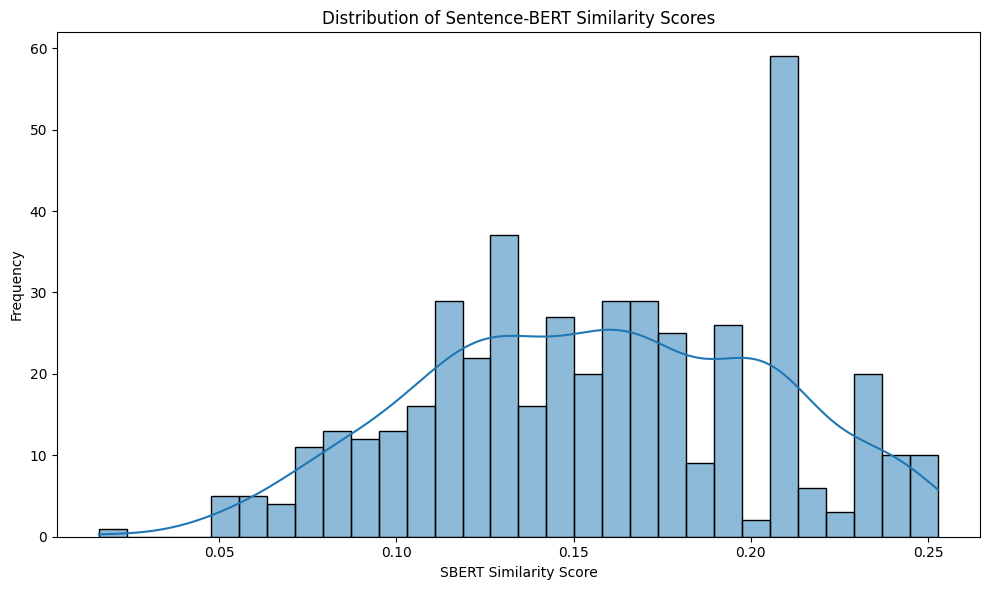

In [104]:
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns

# Load Sentence-BERT model
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

# Encode post content with Sentence-BERT
sbert_embeddings = sbert_model.encode(df['Cleaned Content'].tolist(), convert_to_tensor=True)

# Compute pairwise cosine similarities
cosine_scores = util.pytorch_cos_sim(sbert_embeddings, sbert_embeddings)

# Average similarity for each post
df['SBERT_Similarity'] = cosine_scores.mean(dim=1).cpu().numpy()

# Visualize distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['SBERT_Similarity'], bins=30, kde=True)
plt.title("Distribution of Sentence-BERT Similarity Scores")
plt.xlabel("SBERT Similarity Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### 🔎 Sentence-BERT Vectorization for Semantic Features

In [105]:
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split

# Load a pre-trained Sentence-BERT model
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

# Generate embeddings for post content
sbert_embeddings = sbert_model.encode(df['Cleaned Content'].tolist(), show_progress_bar=True)

# Convert to DataFrame
import numpy as np
sbert_df = pd.DataFrame(sbert_embeddings, columns=[f'sbert_{i}' for i in range(sbert_embeddings.shape[1])])

# Merge with original DataFrame
df = pd.concat([df.reset_index(drop=True), sbert_df.reset_index(drop=True)], axis=1)

# Dummy label (replace this with actual labels if available)
df['SBERT_Label'] = df['Fraud_Prediction'] if 'Fraud_Prediction' in df else np.random.randint(0, 2, len(df))

# Train logistic regression on SBERT features
X_train, X_test, y_train, y_test = train_test_split(sbert_df, df['SBERT_Label'], test_size=0.2, random_state=42)
sbert_clf = LogisticRegression(max_iter=1000)
sbert_clf.fit(X_train, y_train)

# Normalize SBERT similarity to 0-1
df['SBERT_Prob'] = (df['SBERT_Similarity'] - df['SBERT_Similarity'].min()) / (df['SBERT_Similarity'].max() - df['SBERT_Similarity'].min())


Batches: 100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


In [106]:

# Train TF-IDF + Logistic Regression
tfidf = TfidfVectorizer(max_features=100)
X_reviews = tfidf.fit_transform(reviews_corpus + df['Cleaned Content'].tolist())
dummy_labels = [0] * len(reviews_corpus) + [1] * len(df)
clf_text = LogisticRegression().fit(X_reviews, dummy_labels)

X_text = tfidf.transform(df['Cleaned Content'])
df['Text_Prob'] = clf_text.predict_proba(X_text)[:, 1]

# Anomaly Detection
features = ['Post Length', 'Num Comments', 'Total Reactions', 'Angry Ratio', 'Sad Ratio', 'Haha Ratio', 'Love Ratio']
X_behavior = df[features].fillna(0)
anomaly_model = IsolationForest(contamination=0.25, random_state=42)
df['Anomaly_Score'] = -anomaly_model.fit(X_behavior).decision_function(X_behavior)

# Final Score + Export
np.random.seed(42)
df['Trust_Score'] = np.random.uniform(0.5, 1.0, len(df))
df['FraudLens_Score'] = 0.4 * df['SBERT_Prob'] + 0.4 * df['Anomaly_Score'] + 0.2 * (1 - df['Trust_Score'])
df['Fraud_Prediction'] = df['FraudLens_Score'].apply(lambda x: 1 if x > 0.5 else 0)

# Export
df.to_csv("fraudlens_training_output.csv", index=False)
joblib.dump(tfidf, "tfidf_model.pkl")
joblib.dump(clf_text, "logistic_model.pkl")
joblib.dump(anomaly_model, "isolation_model.pkl")
print("✅ Models and results saved.")

print("✅ Training complete. Showing top suspicious posts:")
df[df['Fraud_Prediction'] == 1][['Post Content', 'FraudLens_Score', 'Text_Prob', 'Anomaly_Score']]


C:\Users\hgamage\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


✅ Models and results saved.
✅ Training complete. Showing top suspicious posts:


,Post Content,FraudLens_Score,Text_Prob,Anomaly_Score
291,"SNEAKERS CLUBNegombo Plaza, Main Street- Negom...",0.517231,0.948825,0.052414
299,"SNEAKERS CLUBNegombo Plaza, Main Street- Negom...",0.511028,0.943580,0.105725


### 📊 FraudLens Score Distribution

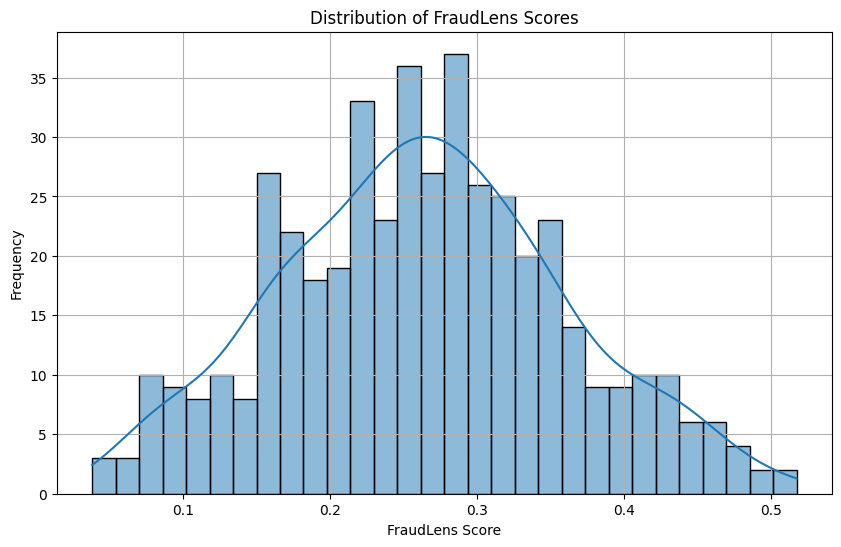

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['FraudLens_Score'], bins=30, kde=True)
plt.title("Distribution of FraudLens Scores")
plt.xlabel("FraudLens Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


### 🔐 Blockchain-Based Identity Verification (Pseudocode)

In [108]:
# Pseudocode: Blockchain for Identity Verification

class DecentralizedIdentity:
    def __init__(self, user_id):
        self.did = self.generate_did(user_id)
        self.reputation = 100
    
    def generate_did(self, user_id):
        import hashlib
        return hashlib.sha256(user_id.encode()).hexdigest()
    
    def flag_user(self, reason):
        self.reputation -= 10
        self.log_to_blockchain(reason)
    
    def log_to_blockchain(self, reason):
        print(f"📜 Logging: {self.did} flagged for {reason}")

# Example usage
user = DecentralizedIdentity("fraudulent_user@example.com")
user.flag_user("Suspicious posting behavior")


📜 Logging: 054d9406110e202ec1eaa0b551ef1001ffb1374df76c4c37c972f62b2d10c395 flagged for Suspicious posting behavior


### Fraud Prediction Outcome Count

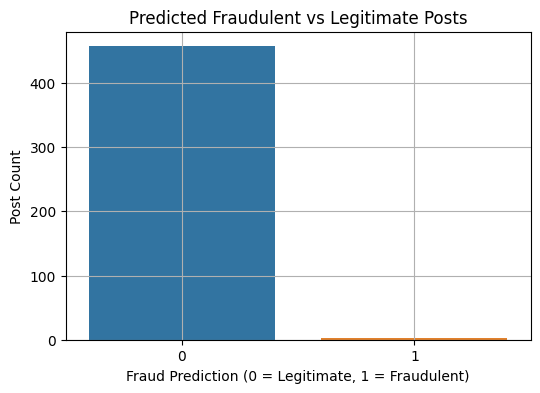

In [109]:
plt.figure(figsize=(6, 4))
sns.countplot(x="Fraud_Prediction", data=df)
plt.title("Predicted Fraudulent vs Legitimate Posts")
plt.xlabel("Fraud Prediction (0 = Legitimate, 1 = Fraudulent)")
plt.ylabel("Post Count")
plt.grid(True)
plt.show()


### Reaction Ratios by Fraud Status

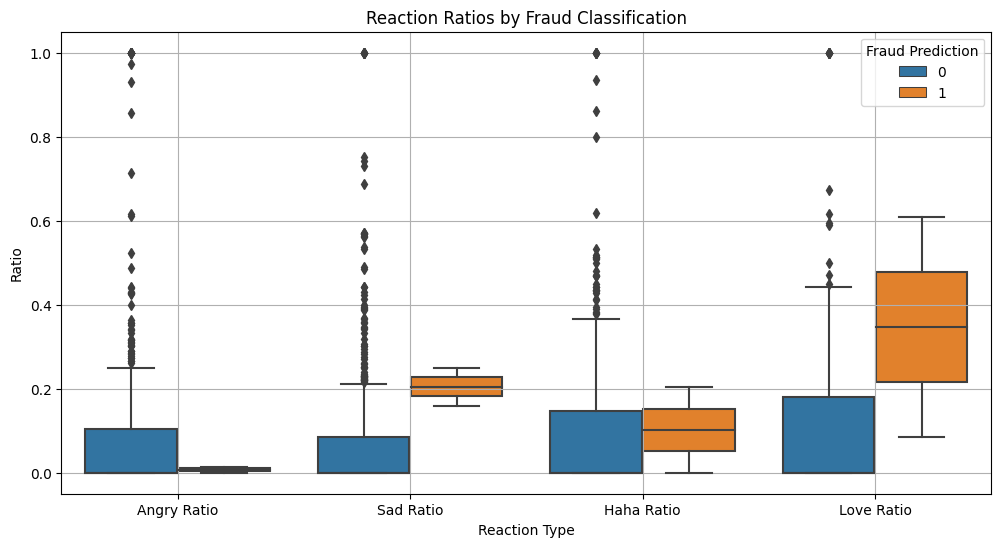

In [110]:
reaction_features = ["Angry Ratio", "Sad Ratio", "Haha Ratio", "Love Ratio"]
melted = df[["Fraud_Prediction"] + reaction_features].melt(id_vars="Fraud_Prediction")

plt.figure(figsize=(12, 6))
sns.boxplot(x="variable", y="value", hue="Fraud_Prediction", data=melted)
plt.title("Reaction Ratios by Fraud Classification")
plt.xlabel("Reaction Type")
plt.ylabel("Ratio")
plt.legend(title="Fraud Prediction")
plt.grid(True)
plt.show()


### Trust Score vs. FraudLens Score Scatter

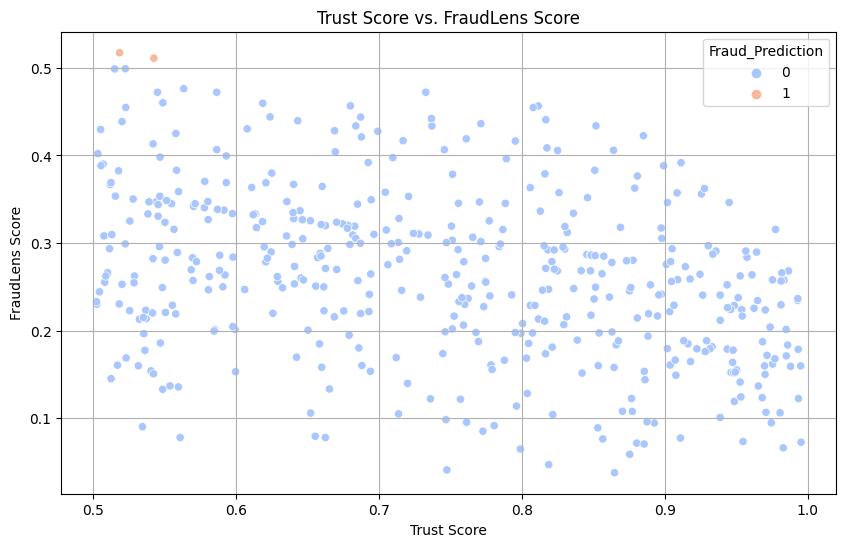

In [111]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Trust_Score", y="FraudLens_Score", hue="Fraud_Prediction", palette="coolwarm")
plt.title("Trust Score vs. FraudLens Score")
plt.xlabel("Trust Score")
plt.ylabel("FraudLens Score")
plt.grid(True)
plt.show()


### Temporal Analysis

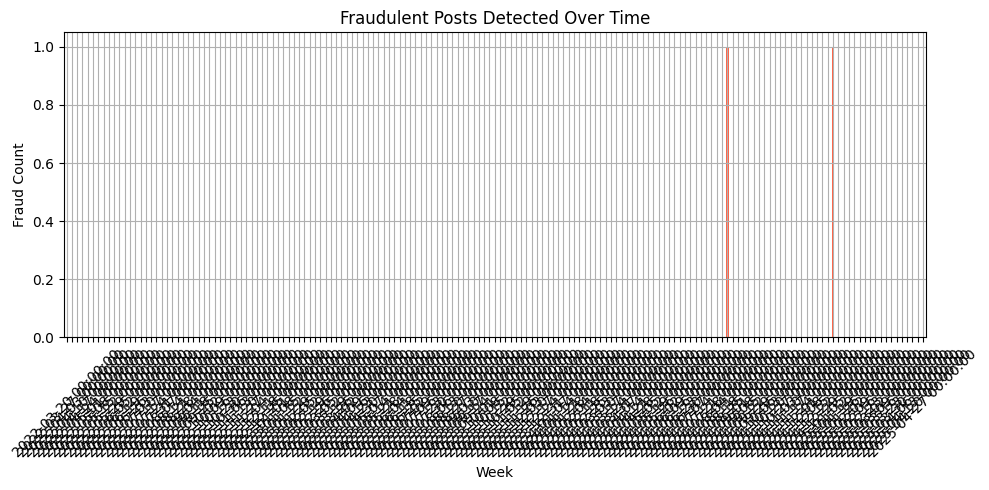

In [112]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors='coerce')
df.set_index("Timestamp", inplace=True)

fraud_over_time = df.resample("W")["Fraud_Prediction"].sum()

plt.figure(figsize=(10, 5))
fraud_over_time.plot(kind="bar", color="tomato")
plt.title("Fraudulent Posts Detected Over Time")
plt.xlabel("Week")
plt.ylabel("Fraud Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


### 4.4.1 Distribution of Post Lengths

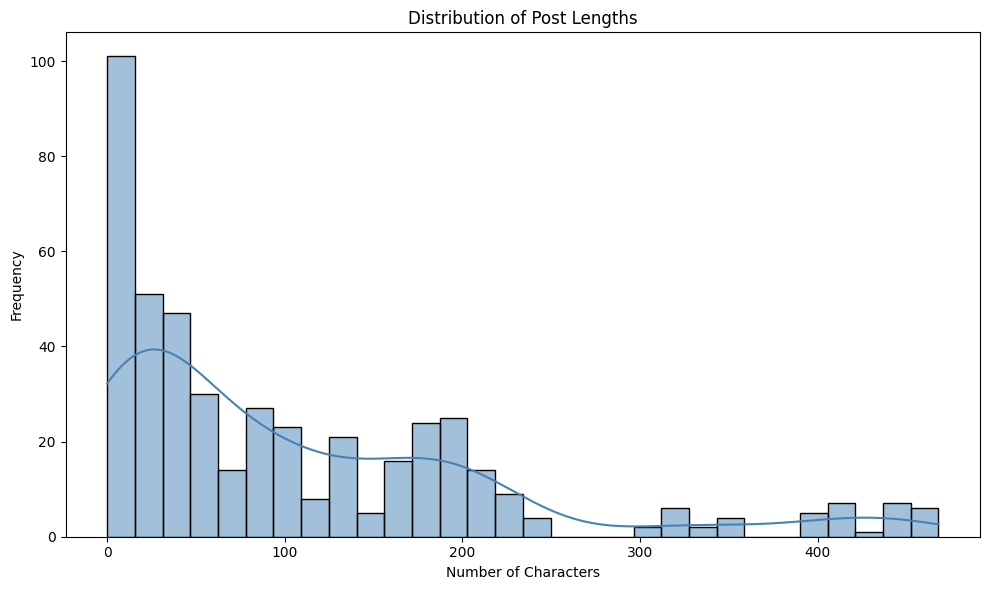

In [113]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Post Length'], bins=30, kde=True, color='steelblue')
plt.title("Distribution of Post Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### 4.4.2 Reaction Ratios by Emotion Type

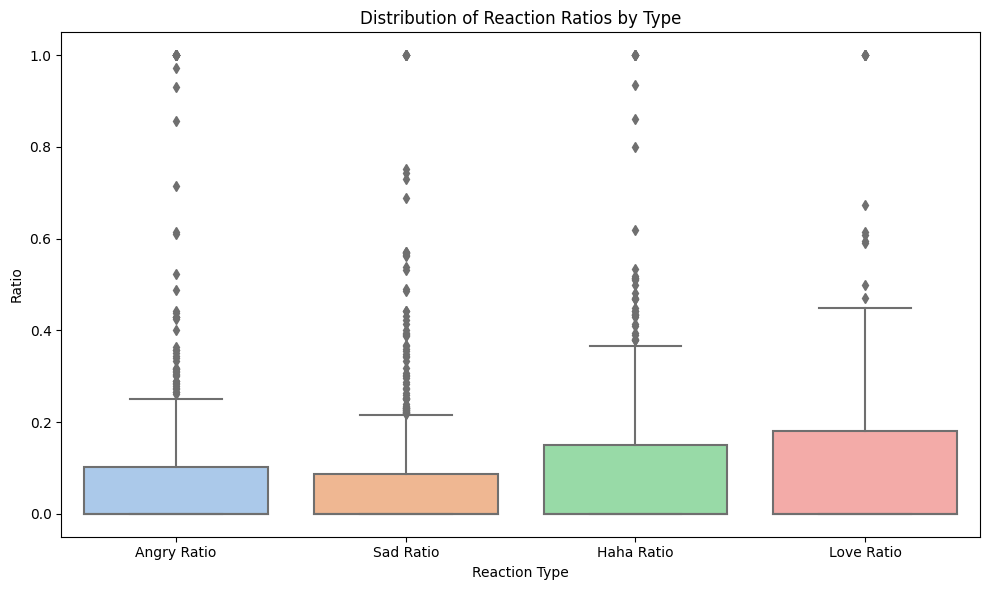

In [114]:
reaction_cols = ['Angry Ratio', 'Sad Ratio', 'Haha Ratio', 'Love Ratio']
df_melted = df[reaction_cols].melt(var_name='Reaction', value_name='Ratio')

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x='Reaction', y='Ratio', palette='pastel')
plt.title("Distribution of Reaction Ratios by Type")
plt.ylabel("Ratio")
plt.xlabel("Reaction Type")
plt.tight_layout()
plt.show()


### 4.4.3 Comments vs. Reactions

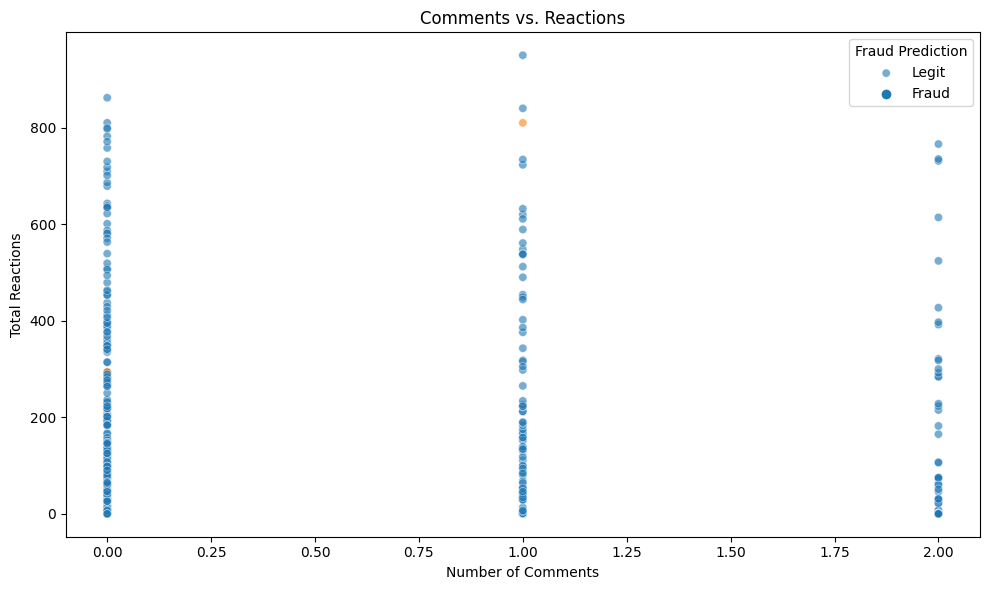

In [115]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Num Comments', y='Total Reactions', hue='Fraud_Prediction', alpha=0.6)
plt.title("Comments vs. Reactions")
plt.xlabel("Number of Comments")
plt.ylabel("Total Reactions")
plt.legend(title="Fraud Prediction", labels=["Legit", "Fraud"])
plt.tight_layout()
plt.show()


### 4.4.4 Behavioral Feature Correlation Matrix

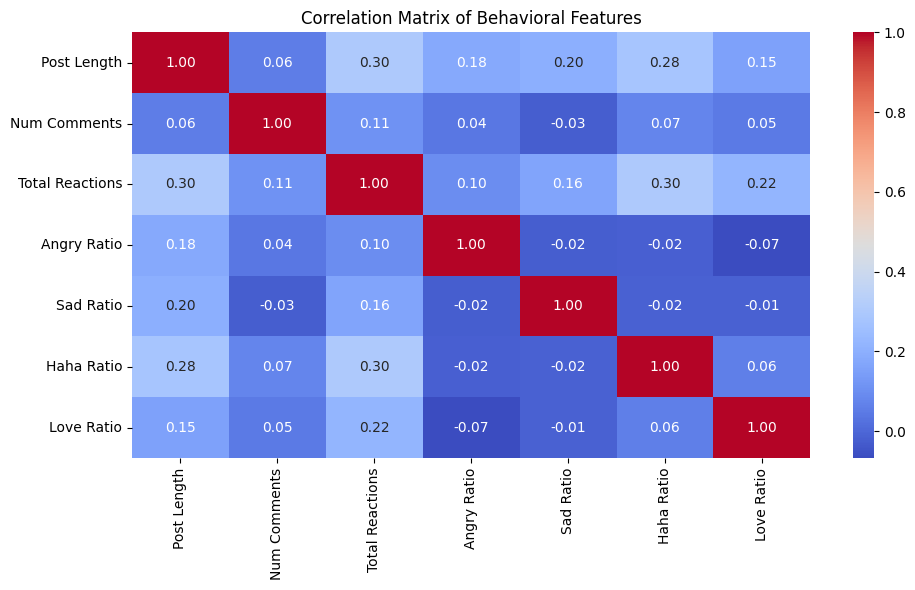

In [116]:
behavior_features = ['Post Length', 'Num Comments', 'Total Reactions', 'Angry Ratio', 'Sad Ratio', 'Haha Ratio', 'Love Ratio']
plt.figure(figsize=(10, 6))
sns.heatmap(df[behavior_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Behavioral Features")
plt.tight_layout()
plt.show()


### 4.5.1 Trust Score Distribution

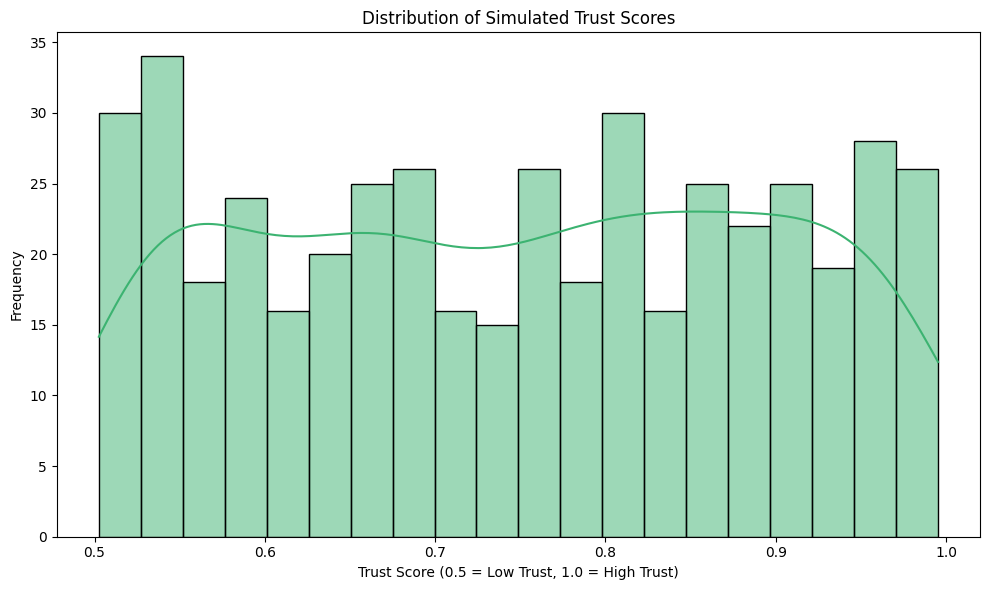

In [117]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Trust_Score'], bins=20, kde=True, color='mediumseagreen')
plt.title("Distribution of Simulated Trust Scores")
plt.xlabel("Trust Score (0.5 = Low Trust, 1.0 = High Trust)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### 4.5.2 Trust Score vs. FraudLens Score

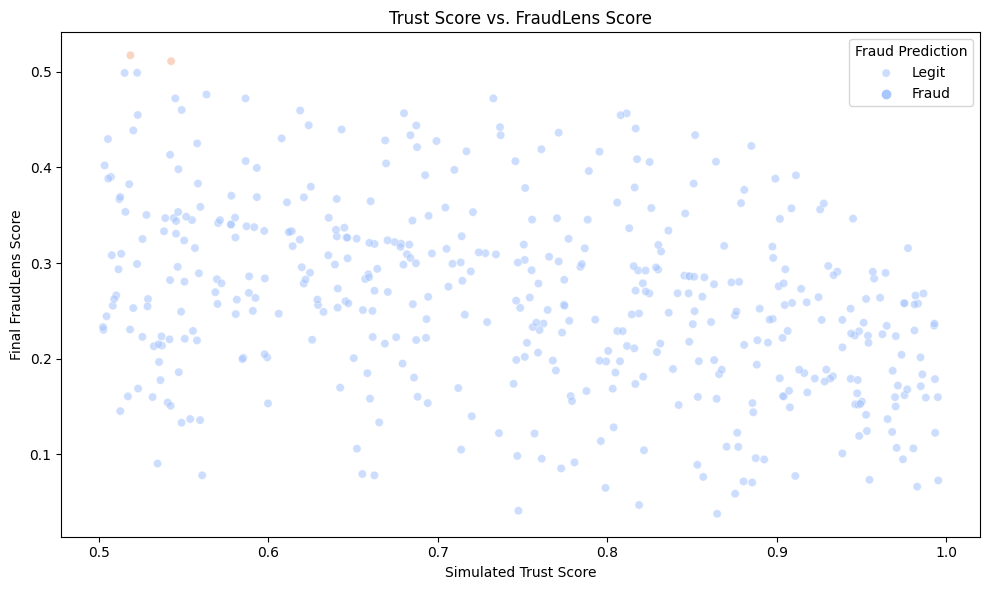

In [118]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Trust_Score', y='FraudLens_Score', hue='Fraud_Prediction', alpha=0.6, palette='coolwarm')
plt.title("Trust Score vs. FraudLens Score")
plt.xlabel("Simulated Trust Score")
plt.ylabel("Final FraudLens Score")
plt.legend(title="Fraud Prediction", labels=["Legit", "Fraud"])
plt.tight_layout()
plt.show()
